# **Violence Detection using CNN+LSTM**





## Installations and Libraries

In [ ]:
!pip install tensorflow


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import math
import datetime as dt
import matplotlib.pyplot as plt
from collections import deque

from moviepy.editor import *
%matplotlib inline
from IPython.display import display
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
# set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.
# This helps maintain the same numbers so we don't get different results every time we run.
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## Reading the data

In [ ]:
# # Connect with google drive to retrieve the data from there.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


['NV_110.mp4', 'NV_112.mp4', 'NV_111.mp4', 'NV_114.mp4', 'NV_113.mp4', 'NV_116.mp4', 'NV_117.mp4', 'NV_115.mp4', 'NV_118.mp4', 'NV_119.mp4', 'NV_12.mp4', 'NV_120.mp4', 'NV_121.mp4', 'NV_128.mp4', 'NV_125.mp4', 'NV_123.mp4', 'NV_13.mp4', 'NV_122.mp4', 'NV_124.mp4', 'NV_129.mp4', 'NV_126.mp4', 'NV_127.mp4', 'NV_136.mp4', 'NV_130.mp4', 'NV_137.mp4', 'NV_14.mp4', 'NV_144.mp4', 'NV_141.mp4', 'NV_131.mp4', 'NV_139.mp4', 'NV_142.mp4', 'NV_134.mp4', 'NV_132.mp4', 'NV_146.mp4', 'NV_135.mp4', 'NV_133.mp4', 'NV_145.mp4', 'NV_140.mp4', 'NV_143.mp4', 'NV_138.mp4', 'NV_161.mp4', 'NV_150.mp4', 'NV_147.mp4', 'NV_148.mp4', 'NV_165.mp4', 'NV_162.mp4', 'NV_164.mp4', 'NV_163.mp4', 'NV_15.mp4', 'NV_156.mp4', 'NV_151.mp4', 'NV_168.mp4', 'NV_159.mp4', 'NV_152.mp4', 'NV_169.mp4', 'NV_167.mp4', 'NV_153.mp4', 'NV_155.mp4', 'NV_149.mp4', 'NV_157.mp4', 'NV_160.mp4', 'NV_158.mp4', 'NV_166.mp4', 'NV_154.mp4', 'NV_16.mp4', 'NV_170.mp4', 'NV_188.mp4', 'NV_186.mp4', 'NV_176.mp4', 'NV_175.mp4', 'NV_178.mp4', 'NV_190.mp

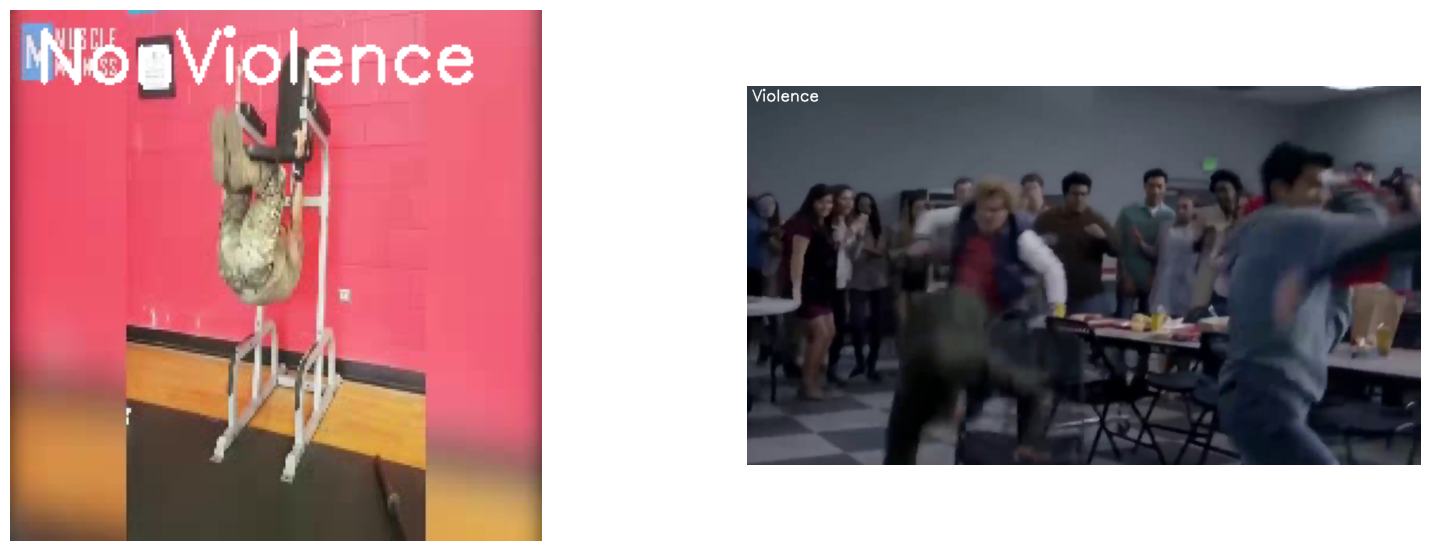

In [ ]:
from inspect import FrameInfo
#create figure with sepecific size
plt.figure(figsize = (40,40))
# to get the labels of data by folder name of directory
class_names = os.listdir('/content/gdrive/MyDrive/vio_data/Real Life Violence Dataset')
# to get random sample from the classes each time we run
# it takes the range length of class name and length of the sample
random_sample = random.sample(range(len(class_names)),2)
# iterating through random videos we get , counter for the index of the video that starts with 1 and video index is for the index of random videos we select
for counter , video_index in enumerate(random_sample,1):
  # retrive the class name from video index that consist of 0 for the first class and 1 for the second class
  select_class = class_names[video_index]
  # retrive a list of names of all videos in the directory folder for each class
  all_videos = os.listdir(f'/content/gdrive/MyDrive/vio_data/Real Life Violence Dataset/{select_class}')
  print(all_videos)
  # select a video from the list of videos we have got for each class
  select_data = random.choice(all_videos)
  # to read the video file that has been selected randomly
  video_reader = cv2.VideoCapture(f'/content/gdrive/MyDrive/vio_data/Real Life Violence Dataset/{select_class}/{select_data}')
  # to read the first frame from the video
  _,frame = video_reader.read()
  # after reading the first frame , stop reading
  video_reader.release()
  # convert the frame from bgr to rgb to be able to display it
  rgb_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
  # to write name of the class as a text on the image
  cv2.putText(rgb_frame , select_class , (10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
  # to put 2 classes beside each other and to show the image
  plt.subplot(5,4,counter)
  plt.imshow(rgb_frame)
  plt.axis('off')


## Data Preprocessing

In [ ]:
# specify the size of the frames
# if size increase the complexity increase and accuracy increase
#64*64 is enough to know what happened in the frames
image_h = 64
image_w = 64
# sequence of the frame that he will take when he slice the video
sequence_frame = 10
# # dataset directory
# dataset = str(os.listdir('/content/drive/MyDrive/vio_data/Real Life Violence Dataset'))
#classes name
classes = ['Violence', 'NonViolence']

In [ ]:
# this function will extract frames from the video
def frames_from_videos(video_path):
  # list to store the frames that have been taken from video
  frames = []
  # to read the video file that has been selected randomly
  video_reader = cv2.VideoCapture(video_path)
  # to get the total number of frames in the video
  #cv2.CAP_PROP_FRAME_COUNT it calculates total number of frames in video
  total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  ''' due to we have a certain number of sequence frames we have to get
       we will skip some frames through interval of time
       so we will divide the total number of frames that we have got from video
       from the sequence frame that i want to get it we generate a number that
       consider as the time interval where next frame we be taken

       '''
  skip_frames = max(int(total_frames/sequence_frame),1)

  # iterate through the video frames
  for counter in range(sequence_frame):
    # know the current postion of the frame
    # cv2.CAP_PROP_POS_FRAMES to get the postion of the frame you take
    ''' counter * skip frames is to read the frames at certain time not from the beginning
        because we want to read certain frames not all frames that we have been selected in
        skip frames then we will read video from this point
    '''
    video_reader.set(cv2.CAP_PROP_POS_FRAMES , counter * skip_frames)

    # reading the frames from the video in certain point of time
    # sec is boolean value if it reads the frame or not
    # frame is the real frame
    sec , frame = video_reader.read()
    # to check if the frames has been sucessfuly read or not
    if not sec:
      break

    # resize the frame to fixed height and width
    frame_resize = cv2.resize(frame ,(image_h,image_w))
    # normalize the resized frame to be from 0 to 1 to help in training
    frame_normalization = frame_resize/255
    # append the frame into the frame list
    frames.append(frame_normalization)

  # video release after taking frames
  video_reader.release()
  # retrun frame list
  return frames

In [ ]:
# it will takes the frames that has been extracted and select it to classes and create normal dataset
def new_dataset():
  # to store extracted frames
  extracted_frames = []
  # to store labels
  labels = []
  # to store file path
  file_path = []

  # iterate through all the classes we have
  for class_index , class_name in enumerate (classes):
    # print hte name of the class whose frames has been extracted
    print(f'Extracted frames from class:{class_name}')
    # list of videos in specific directory
    list_video = os.listdir(os.path.join('/content/gdrive/MyDrive/vio_data/Real Life Violence Dataset',class_name))
    #iterate through the videos in the directory
    for vid in list_video:
      # to get the path of video
      video_path = os.path.join('/content/gdrive/MyDrive/vio_data/Real Life Violence Dataset' , class_name , vid)
      # extract frames from function frames from video
      # we will get 10 frames from each video in each class
      frames = frames_from_videos(video_path)

      # check if the number of frames the same as our sequence length
      if len(frames) == sequence_frame:
        # if true then append the data of video in lists
        extracted_frames.append(frames)
        labels.append(class_index)

        file_path.append(video_path)
# converting list to numpy array
  extracted_frames = np.asarray(extracted_frames)
  labels = np.array(labels)

  # return frames with labels and path
  return extracted_frames, labels , file_path

In [ ]:
# create dataset
features, cla, path = new_dataset()

Extracted frames from class:Violence
Extracted frames from class:NonViolence


In [ ]:
# one hot encode the categorical column
from tensorflow.keras.utils import to_categorical
encoding_class_labels = to_categorical(cla)

## Data Splitting

In [ ]:
# splitting data into training and testing
# 80% train and 20% test
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(features,encoding_class_labels,test_size = 0.20 , shuffle = True ,random_state = seed_constant )

In [ ]:
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)
print("x_test:",x_test.shape)
print("y_test:",y_test.shape)

x_train: (1611, 10, 64, 64, 3)
y_train: (1611, 2)
x_test: (403, 10, 64, 64, 3)
y_test: (403, 2)


## ConvLSTM Model Implementation

Since we are working with frames of videos, The most suitable algorithm to use is ConvLstm; a variant of an LSTM network that contains convolutions operations in the network.

For video classification, this approach effectively captures the spatial relation in the individual frames and the temporal relation across the different frames.

Embedding Conv layers along LSTM makes it capable of taking 3-dimensional inputs: width, height, and the number of channels.

### Construct the model's architecture

The model consists of 4 ConvLSTM2D layers to capture complex features and a dense layer at the end serving as the output layer for classification.

Each ConvLSTM2D layer has a tanh activation function since it's the most suitable for applications including sequential data.

Each ConvLSTM2D layer is folllowed by a MaxPooling3D layer for dimensionality reduction in 3D data; it helps focus on the most important features. Then the TimeDistributed Layer helps apply dropout to each frame or time step individually.

Because the dense layers works with 1D arrays, we need to flatten the output of the preceding layer before it enters the fully connected layer.

Lastly, the Dense layer is a fully connected layer in which each neuron is connected to every neuron in the previous layer. It is used as the final layer for classification.

For dense layers, the common activation function used is softmax; it normalizes the output values into a probability distribution, ensuring that the sum of probabilities across all classes equals 1.

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Build the model's architecture
    # Layer 1
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (sequence_frame,
                                                                                      image_h, image_w, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.3)))

    # Layer 2
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh',
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.3)))

    # Layer 3
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh',
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    model.add(TimeDistributed(Dropout(0.3)))

    # Layer 4
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh',
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))

    model.add(Flatten())

    model.add(Dense(len(classes), activation = "softmax"))

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

### Model Summary

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 10, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 10, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 10, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 10, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 10, 15, 15, 8)     0         
 g3D)                                                            
                                                        

### Check the model's structure

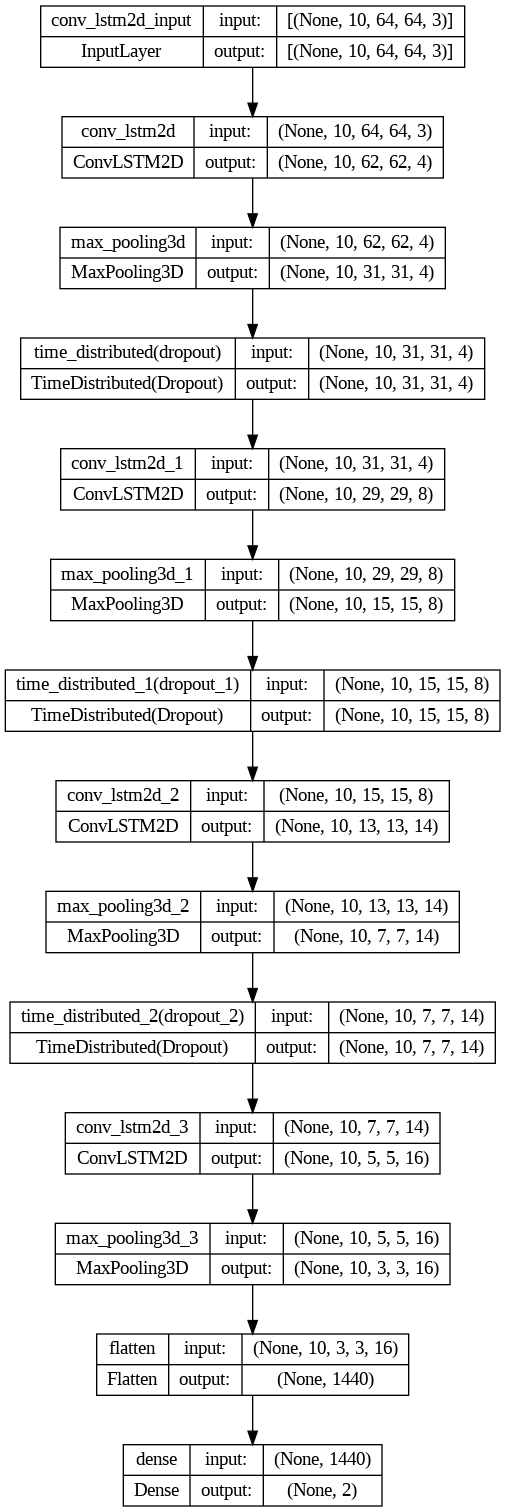

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### Compile and Train the Model

We are going to apply early stopping to help avoid overfitting; it's a technique terminates training when the performance of the model on a validation dataset stops improving. The patience is set to 10 meaning that the model will wait for 10 epochs before stopping training after no improvement is observed in the validation loss.

The loss function used is binary crossentropy since we are working on a binary classification task.

For optimization, we are going to use Adaptive Learning Rate Optimization (ADAM); it adapts the learning rate during training based on the exponentially decaying average of past gradients.



In [ ]:
# Create an Instance of Early Stopping Callback
# mode = 'min' --> the monitored quantity should be decreasing
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = x_train, y = y_train, epochs = 30, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/30
322/322 [==============================] - 53s 119ms/step - loss: 0.6940 - accuracy: 0.5109 - val_loss: 0.6798 - val_accuracy: 0.5139
Epoch 2/30
322/322 [==============================] - 35s 108ms/step - loss: 0.6017 - accuracy: 0.6708 - val_loss: 0.6037 - val_accuracy: 0.6625
Epoch 3/30
322/322 [==============================] - 37s 114ms/step - loss: 0.5129 - accuracy: 0.7469 - val_loss: 0.4797 - val_accuracy: 0.7368
Epoch 4/30
322/322 [==============================] - 36s 112ms/step - loss: 0.4619 - accuracy: 0.7733 - val_loss: 0.5317 - val_accuracy: 0.7183
Epoch 5/30
322/322 [==============================] - 37s 115ms/step - loss: 0.4351 - accuracy: 0.7880 - val_loss: 0.4176 - val_accuracy: 0.7957
Epoch 6/30
322/322 [==============================] - 37s 116ms/step - loss: 0.3931 - accuracy: 0.8082 - val_loss: 0.4442 - val_accuracy: 0.7926
Epoch 7/30
322/322 [==============================] - 37s 115ms/step - loss: 0.3433 - accuracy: 0.8354 - val_loss: 0.3856 - val_ac

### Evaluate the model

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(x_test, y_test)

13/13 [==============================] - 1s 56ms/step - loss: 0.4066 - accuracy: 0.8040


### Save the model

Saving the model will help us avoid training it from scratch everytime we run.

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt,date_time_format)

# Define a useful name for the model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
convlstm_model.save(model_file_name)

  saving_api.save_model(



## Visualize the Model's Accuracy and Loss Curves

### Create a function to plot the accuracy and loss

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

### Accuracy curves

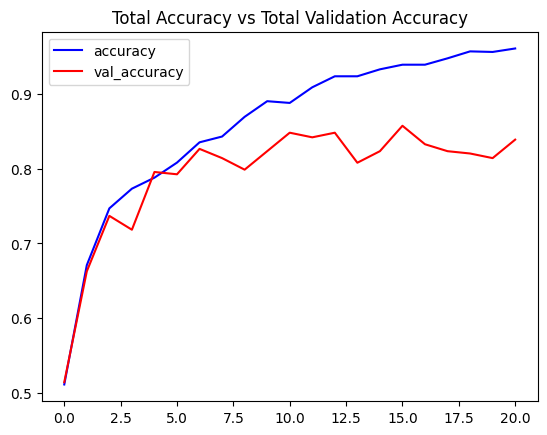

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

### Loss Curves

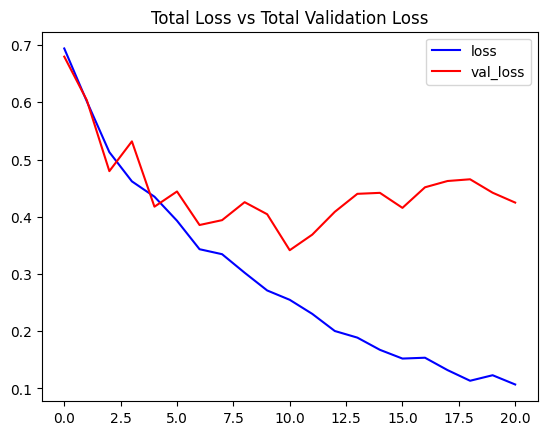

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

## Get the confusion Matrix, Accuracy, F1 Score, Recall, Precision

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Make predictions on the test data
y_pred_prob = convlstm_model.predict([x_test])

#Convert the predicted probabilities to class predictions
#Select the index with the maximum probability (select the class with the maximum)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert true labels to class indices
y_true = np.argmax(y_test, axis=1)


# Calculate metrics for face prediction
#weighted -> metrics are computed for each class and then averaged
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1_score = f1_score(y_true, y_pred, average='weighted')


# Print metrics for face prediction
print("Metrics for Face Prediction:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

13/13 [==============================] - 1s 38ms/step
Metrics for Face Prediction:
Accuracy: 0.8040
Precision: 0.8065
Recall: 0.8040
F1-score: 0.8021


[[193  27]
 [ 52 131]]


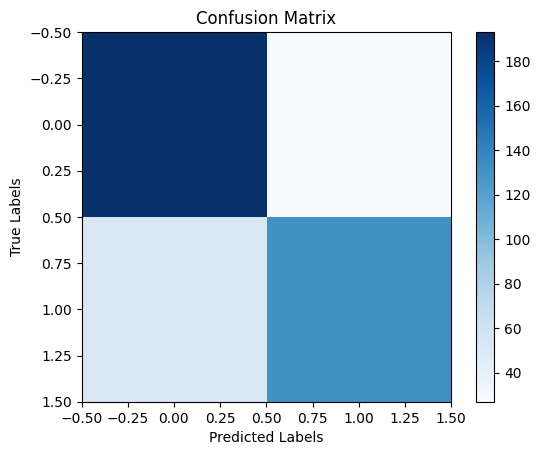

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print(cm)

# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Perform prediction on different videos

### Create a function to perform prediction on videos

In [ ]:
def predict(video_file_path, sequence_frame):
    '''
    This function will perform prediction on a video using the Convlstm model.
    Args:
    video_file_path:  The path of the video we want to predict.
    sequence_frame:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/sequence_frame),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(sequence_frame):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (image_h, image_w))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = classes[predicted_label]
    # if the class label is violence so don't show the video and just show the image that is this video is violence
    if predicted_class_name == 'Violence':
       print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
       i = cv2.imread('/content/warning.png')
       plt.imshow(i)
       plt.axis('off')

    elif predicted_class_name == 'NonViolence':
      print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
      video = VideoFileClip(video_file_path)
      display(video.ipython_display())

# Release the VideoCapture object.
video_reader.release()

(-0.5, 1795.5, 1007.5, -0.5)

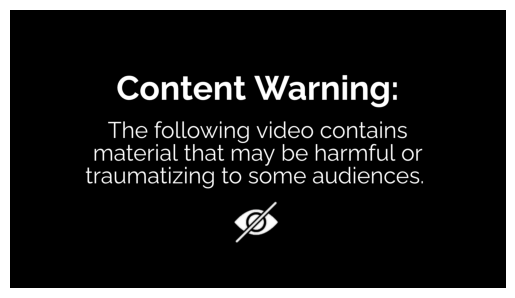

In [ ]:
from google.colab.patches import cv2_imshow
i = cv2.imread('/content/warning.png')
plt.imshow(i)
plt.axis('off')


### 1st video prediction

1/1 [==============================] - 1s 1s/step
Action Predicted: Violence
Confidence: 0.9981212019920349


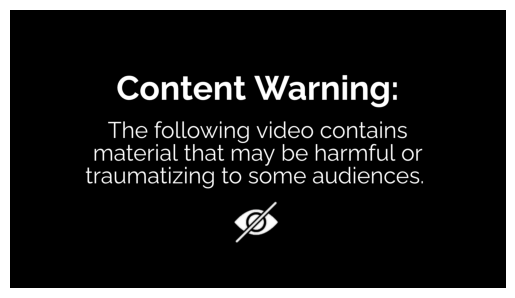

In [ ]:
# The path of the video
video_file_path = "/content/fight.mp4"

# Call the predict function
predict(video_file_path, sequence_frame)


1/1 [==============================] - 0s 39ms/step
Action Predicted: Violence
Confidence: 0.9998180270195007


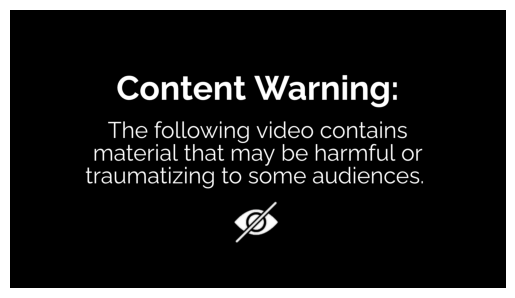

In [ ]:
# The path of the video
video_file_path = "/content/fight3.mp4"

# Call the predict function
predict(video_file_path, sequence_frame)

###2nd video prediction


In [ ]:
# The path of the video
video_file_path = "/content/NV_15.mp4"

# Call the predict function
predict(video_file_path, sequence_frame)


1/1 [==============================] - 2s 2s/step
Action Predicted: NonViolence
Confidence: 0.9874094128608704
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### 3rd video prediction

In [ ]:
# The path of the video
video_file_path2 = "flowers.mp4"

# Call the predict function
predict(video_file_path2, sequence_frame)

# Display the input video.
VideoFileClip(video_file_path2, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 65ms/step
Action Predicted: NonViolence
Confidence: 0.844649076461792
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  98%|█████████▊| 280/285 [00:00<00:00, 414.41it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file flowers.mp4, 151200 bytes wanted but 0 bytes read,at frame 284/285, at time 9.47/9.47 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### 4th video prediction

In [ ]:
# The path of the video
video_file_path3 = "sama.mp4"

# Call the predict function
predict(video_file_path3, sequence_frame)

# Display the input video.
VideoFileClip(video_file_path3, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 66ms/step
Action Predicted: NonViolence
Confidence: 0.65884929895401
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
